# ISYE 6740 Final Project - omerkhan & afante3

In [3]:
import pandas as pd
import requests
import numpy as np
import nba_api.stats.endpoints as nba_stats
from nba_api.stats.endpoints import leagueleaders
from nba_api.stats.endpoints import commonplayerinfo
from nba_api.stats.endpoints import teamyearbyyearstats
from nba_api.stats.static import teams
import time
import concurrent.futures
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from nba_api.stats.endpoints import leaguestandings
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns

## Pre-processing steps needed to construct the dataset used for training.  However, you can skip ahead to model training which loads the equivalent data from a static file.

#### Using NBA Season data from 2010-2020

In [171]:
seasons = [
    '2010-11',
    '2011-12',
    '2012-13',
    '2013-14',
    '2014-15',
    '2015-16',
    '2016-17',
    '2017-18',
    '2018-19',
    '2019-20'
]

#### Leveraging the NBA API, we can build a dataset of player and team information over our season period and calculate per game averages for each season and player across the period. The NBA_API can be viewed in further detail [here](https://github.com/swar/nba_api)

In [172]:
total_player_stats_df = pd.DataFrame()

for season in seasons:
    league_leaders = leagueleaders.LeagueLeaders(
      season=season,
      season_type_all_star="Regular Season",
      stat_category_abbreviation='PTS'
    ).get_data_frames()[0]

    league_leaders_df = league_leaders[['PLAYER_ID', 'PLAYER', 'TEAM_ID', 'TEAM', 'GP', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PTS', 'EFF', 'AST_TOV']]
    league_leaders_df = league_leaders_df.copy()
    league_leaders_df.loc[:, 'PPG'] = league_leaders_df['PTS'] / league_leaders_df['GP']
    league_leaders_df.loc[:, 'RPG'] = league_leaders_df['REB'] / league_leaders_df['GP']
    league_leaders_df.loc[:, 'APG'] = league_leaders_df['AST'] / league_leaders_df['GP']
    league_leaders_df.loc[:, 'SPG'] = league_leaders_df['STL'] / league_leaders_df['GP']
    league_leaders_df.loc[:, 'BPG'] = league_leaders_df['BLK'] / league_leaders_df['GP']
    league_leaders_df.loc[:, 'TPG'] = league_leaders_df['TOV'] / league_leaders_df['GP']
    league_leaders_df['YEAR'] = season

    league_leaders_pg_df = league_leaders_df[['YEAR', 'PLAYER_ID', 'PLAYER', 'TEAM_ID', 'TEAM', 'GP', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'EFF', 'AST_TOV', 'PPG', 'RPG', 'APG', 'SPG', 'BPG', 'TPG']]

    total_player_stats_df = pd.concat([total_player_stats_df, league_leaders_pg_df], sort=False)


KeyboardInterrupt: 

In [ ]:
total_player_stats_df

##### Given our goal to try to predict the All-NBA selections, we need to be cognizant of the positional limitations that have typically occurred during voting, historically, Basketball is played with 5 major positions. Point Guard, Shooting Guard, Small Forward, Power Forward, and Center. Given these limitations we want to add the notion of position to our dataset to ensure that we can do some post processing considerations later.

In [ ]:
def get_player_position(player_id):
  try:
    player_info = commonplayerinfo.CommonPlayerInfo(player_id=player_id)
    player_info_dict = player_info.get_normalized_dict()
    position = player_info_dict['CommonPlayerInfo'][0]['POSITION']
    return position
  except Exception as e:
    print(f"Unable to Fetch Position {player_id}: {e}")
    return None

def assign_positions_to_df(df, player_positions):
  df['POS'] = player_positions[df['PLAYER_ID']]
  return df

##### Given many players play across multiple years, we need to further filter this to unique player ids:

In [ ]:
unique_player_ids = total_player_stats_df['PLAYER_ID'].unique()

In [ ]:
player_pos = {}
for player_id in unique_player_ids:
    try:
        position = get_player_position(player_id)
        player_pos[player_id] = position
        print(f"Identified Player ID {player_id}, Position: {position}")
    except Exception as e:
        print(f"Error with Player ID {player_id}: {e}")
    time.sleep(1)


In [ ]:
def get_position(player_id):
  try:
    position = get_player_position(player_id)
    return player_id, position
  except Exception as e:
    print(f"Error with Player ID {player_id}: {e}")
    return player_id, None

player_pos = {}
with concurrent.futures.ThreadPoolExecutor() as executor:
  futures = {executor.submit(get_position, player_id): player_id for player_id in unique_player_ids}
  for future in concurrent.futures.as_completed(futures):
    player_id, position = future.result()
    if position is not None:
        player_pos[player_id] = position
        print(f"Identified Player ID {player_id}, Position: {position}")
    time.sleep(1)

##### We manually have built a dictionary containing the previous 10 years of All-NBA player selections ignoring the 3 different levels (1st, 2nd, 3rd team) and consolidating these selections across seasons.

In [ ]:
all_nba_selections = {
    "2010-11": ["Kevin Durant", "Pau Gasol", "LaMarcus Aldridge", "LeBron James", "Dirk Nowitzki", "Zach Randolph", "Dwight Howard", "Amar'e Stoudemire", "Al Horford", "Kobe Bryant", "Dwyane Wade", "Manu Ginóbili", "Derrick Rose", "Russell Westbrook", "Chris Paul"],
    "2011-12": ["LeBron James", "Kevin Love", "Carmelo Anthony", "Kevin Durant", "Blake Griffin", "Dirk Nowitzki", "Dwight Howard", "Andrew Bynum", "Tyson Chandler", "Kobe Bryant", "Tony Parker", "Dwyane Wade", "Chris Paul", "Russell Westbrook", "Rajon Rondo"],
    "2012-13": ["LeBron James", "Carmelo Anthony", "David Lee", "Kevin Durant", "Blake Griffin", "Paul George", "Tim Duncan", "Marc Gasol", "Dwight Howard", "Kobe Bryant", "Tony Parker", "Dwyane Wade", "Chris Paul", "Russell Westbrook", "James Harden"],
    "2013-14": ["Kevin Durant", "Blake Griffin", "Paul George", "LeBron James", "Kevin Love", "LaMarcus Aldridge", "Joakim Noah", "Dwight Howard", "Al Jefferson", "James Harden", "Stephen Curry", "Goran Dragić", "Chris Paul", "Tony Parker", "Damian Lillard"],
    "2014-15": ["LeBron James", "LaMarcus Aldridge", "Blake Griffin", "Anthony Davis", "Pau Gasol", "Tim Duncan", "Marc Gasol", "DeMarcus Cousins", "DeAndre Jordan", "James Harden", "Russell Westbrook", "Klay Thompson", "Stephen Curry", "Chris Paul", "Kyrie Irving"],
    "2015-16": ["Kawhi Leonard", "Kevin Durant", "Paul George", "LeBron James", "Draymond Green", "LaMarcus Aldridge", "DeAndre Jordan", "DeMarcus Cousins", "Andre Drummond", "Stephen Curry", "Damian Lillard", "Klay Thompson", "Russell Westbrook", "Chris Paul", "Kyle Lowry"],
    "2016-17": ["Kawhi Leonard", "Kevin Durant", "Jimmy Butler", "LeBron James", "Giannis Antetokounmpo", "Draymond Green", "Anthony Davis", "Rudy Gobert", "DeAndre Jordan", "James Harden", "Stephen Curry", "John Wall", "Russell Westbrook", "Isaiah Thomas", "DeMar DeRozan"],
    "2017-18": ["Kevin Durant", "LaMarcus Aldridge", "Jimmy Butler", "LeBron James", "Giannis Antetokounmpo", "Paul George", "Anthony Davis", "Joel Embiid", "Karl-Anthony Towns", "James Harden", "DeMar DeRozan", "Victor Oladipo", "Damian Lillard", "Russell Westbrook", "Stephen Curry"],
    "2018-19": ["Giannis Antetokounmpo", "Kevin Durant", "Blake Griffin", "Paul George", "Kawhi Leonard", "LeBron James", "Nikola Jokić", "Joel Embiid", "Rudy Gobert", "James Harden", "Damian Lillard", "Russell Westbrook", "Stephen Curry", "Kyrie Irving", "Kemba Walker"],
    "2019-20": ["LeBron James", "Kawhi Leonard", "Jimmy Butler", "Giannis Antetokounmpo", "Pascal Siakam", "Jayson Tatum", "Anthony Davis", "Nikola Jokić", "Rudy Gobert", "James Harden", "Damian Lillard", "Ben Simmons", "Luka Dončić", "Chris Paul", "Russell Westbrook"]
}


##### We need a binary classifier to determine whether a player was selected as All-NBA across the season in question, the below helper and lambda function allow us to also add this classification to our dataset.

In [ ]:
def assign_all_nba_status(df, all_nba_dict):
  def is_all_nba(player, year):
      return player in all_nba_dict.get(year, [])
  df['is_all_nba'] = df.apply(lambda row: is_all_nba(row['PLAYER'], row['YEAR']), axis=1)
  return df

total_player_w_all_nba_df =  assign_all_nba_status(total_player_stats_df, all_nba_selections)

##### Similarly, we can use our previously defined player dictionary to assign positions to the players:

In [ ]:
def assign_pos(df, player_pos):
  def get_pos(player_id):
      return position in player_pos.get(player_id, "")
  df['POSITION'] = df.apply(lambda row: player_pos[row['PLAYER_ID']], axis=1)
  return df

In [ ]:
total_player_w_pos_nba_df =  assign_pos(total_player_w_all_nba_df, player_pos)

In [ ]:
total_player_w_pos_nba_df.to_csv('full_player_data_10-20.csv', index=False)

#### Alternatively, you can use the static, pre-constructed dataset with position loaded so you don't need to wait for the labeling to run above.

In [3]:
total_player_w_pos_nba_df = pd.read_csv("data/full_player_data_10-20.csv")
total_player_w_pos_nba_df['season_start_year'] = total_player_w_pos_nba_df['YEAR'].apply(lambda x: int(x.split('-')[0]))
total_player_w_pos_nba_df

,YEAR,PLAYER_ID,PLAYER,TEAM_ID,TEAM,GP,FG_PCT,FG3_PCT,FT_PCT,EFF,AST_TOV,PPG,RPG,APG,SPG,BPG,TPG,is_all_nba,POSITION,season_start_year
0,2010-11,201142,Kevin Durant,1610612760,OKC,78,0.462,0.350,0.880,1946,0.98,27.705128,6.833333,2.743590,1.128205,0.974359,2.794872,True,Forward,2010
1,2010-11,2544,LeBron James,1610612748,MIA,79,0.510,0.330,0.759,2258,1.95,26.721519,7.468354,7.012658,1.569620,0.632911,3.594937,True,Forward,2010
2,2010-11,977,Kobe Bryant,1610612747,LAL,82,0.451,0.323,0.828,1754,1.60,25.341463,5.109756,4.731707,1.207317,0.146341,2.963415,True,Forward-Guard,2010
3,2010-11,201565,Derrick Rose,1610612741,CHI,81,0.445,0.332,0.858,1872,2.24,25.012346,4.074074,7.691358,1.049383,0.629630,3.432099,True,Guard,2010
4,2010-11,2405,Amar'e Stoudemire,1610612752,NYK,78,0.502,0.435,0.792,1918,0.81,25.269231,8.153846,2.589744,0.910256,1.923077,3.205128,True,Forward-Center,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4928,2019-20,1629676,Isaiah Roby,1610612760,OKC,3,0.000,0.000,0.000,0,0.00,0.000000,0.666667,0.000000,0.000000,0.000000,0.333333,False,Forward,2019
4929,2019-20,1629122,J.P. Macura,1610612739,CLE,1,0.000,0.000,0.000,0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,False,Guard,2019
4930,2019-20,1629716,Marques Bolden,1610612739,CLE,1,0.000,0.000,0.000,3,0.00,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,False,Center,2019
4931,2019-20,1629742,Stanton Kidd,1610612762,UTA,4,0.000,0.000,0.000,-1,0.50,0.000000,0.750000,0.250000,0.000000,0.000000,0.500000,False,Forward,2019


In [141]:
def fetch_season_data(season):
    standings = leaguestandings.LeagueStandings(season=season)
    return standings.get_data_frames()[0]

all_seasons_data = pd.concat([fetch_season_data(season) for season in seasons])
all_seasons_data['Start_Year'] = all_seasons_data['SeasonID'].str[1:]
team_winning_df = all_seasons_data[['WinPCT', 'Start_Year', 'TeamID']]
team_winning_df['Start_Year']  = team_winning_df['Start_Year'].astype(int)

/var/folders/tt/_0j7v6r90_s6mr6y9p1hv1lw0000gn/T/ipykernel_11593/3922218746.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_winning_df['Start_Year']  = team_winning_df['Start_Year'].astype(int)


In [144]:
final_df = total_player_w_pos_nba_df.merge(team_winning_df, left_on=['TEAM_ID','season_start_year'], right_on=['TeamID','Start_Year'], how='inner')
final_df

,YEAR,PLAYER_ID,PLAYER,TEAM_ID,TEAM,GP,FG_PCT,FG3_PCT,FT_PCT,EFF,...,APG,SPG,BPG,TPG,is_all_nba,POSITION,season_start_year,WinPCT,Start_Year,TeamID
0,2010-11,201142,Kevin Durant,1610612760,OKC,78,0.462,0.350,0.880,1946,...,2.743590,1.128205,0.974359,2.794872,True,Forward,2010,0.671,2010,1610612760
1,2010-11,201566,Russell Westbrook,1610612760,OKC,82,0.442,0.330,0.842,1835,...,8.170732,1.890244,0.365854,3.853659,True,Guard,2010,0.671,2010,1610612760
2,2010-11,201935,James Harden,1610612760,OKC,82,0.436,0.349,0.843,999,...,2.146341,1.121951,0.292683,1.292683,False,Guard,2010,0.671,2010,1610612760
3,2010-11,201586,Serge Ibaka,1610612760,OKC,82,0.543,0.000,0.750,1282,...,0.268293,0.378049,2.414634,0.865854,False,Forward,2010,0.671,2010,1610612760
4,2010-11,1737,Nazr Mohammed,1610612760,OKC,75,0.522,0.000,0.598,683,...,0.306667,0.400000,0.746667,0.933333,False,Center,2010,0.671,2010,1610612760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4928,2019-20,1628476,Derrick Walton Jr.,1610612765,DET,26,0.462,0.417,0.778,75,...,1.038462,0.269231,0.000000,0.192308,False,Guard,2019,0.303,2019,1610612765
4929,2019-20,1629663,Louis King,1610612765,DET,10,0.381,0.364,0.000,19,...,0.500000,0.200000,0.000000,0.200000,False,Forward,2019,0.303,2019,1610612765
4930,2019-20,1629017,Khyri Thomas,1610612765,DET,8,0.294,0.357,0.500,7,...,0.375000,0.375000,0.000000,0.375000,False,Guard,2019,0.303,2019,1610612765
4931,2019-20,1629648,Jordan Bone,1610612765,DET,10,0.250,0.200,0.000,8,...,0.800000,0.100000,0.000000,0.200000,False,Guard,2019,0.303,2019,1610612765


In [169]:
final_df.to_csv('2010-2020_final_df.csv', index=False)

## Start here to use pre-constructed dataset and go into model experimentation.

In [97]:
final_df = pd.read_csv('data/2010-2020_final_df.csv')

In [103]:

features = ['GP', 'PPG', 'RPG', 'APG', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'SPG', 'BPG', 'TPG',  'is_all_nba', 'WinPCT']


X = final_df[features + ['PLAYER']  + ['YEAR']].drop('is_all_nba', axis=1)
y = final_df['is_all_nba']

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Extract player names and then drop the 'PLAYER' column
test_player_names = X_test['PLAYER'].reset_index(drop=True)
test_years = X_test['YEAR'].reset_index(drop=True)
X_train = X_train.drop('PLAYER', axis=1)
X_test = X_test.drop('PLAYER', axis=1)
X_train = X_train.drop('YEAR', axis=1)
X_test = X_test.drop('YEAR', axis=1)

## BINARY CLASSIFICATION

##### Taking our more complete data frame, we can do a few additional pre-processing steps before using a RandomForestClassifier. As one can see in the code below, splitting the data into sections before and after 2017, and using is_all_nba as our feature for our training variable, before initializing and fitting our Random Forest.

In [104]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = RandomForestClassifier()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

       False       0.99      1.00      0.99      1434
        True       0.86      0.54      0.67        46

    accuracy                           0.98      1480
   macro avg       0.92      0.77      0.83      1480
weighted avg       0.98      0.98      0.98      1480



##### We can now sort our features and plot them to give us visual reference for the importance of each

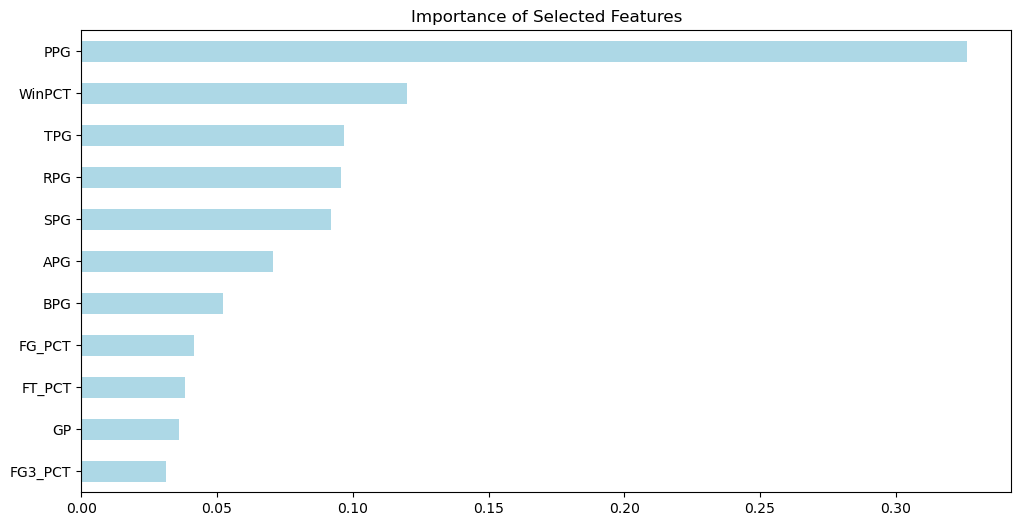

In [105]:
feature_importances = model.feature_importances_
features = X_train.columns
importances = pd.Series(feature_importances, index=features)
importances_sorted = importances.sort_values()

plt.figure(figsize=(12,6))
importances_sorted.plot(kind='barh', color='lightblue')
plt.title('Importance of Selected Features')
plt.show()


## Gradient Boost Classification

In [106]:
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_test)
print(classification_report(y_test, gb_predictions))


              precision    recall  f1-score   support

       False       0.99      0.99      0.99      1434
        True       0.75      0.59      0.66        46

    accuracy                           0.98      1480
   macro avg       0.87      0.79      0.82      1480
weighted avg       0.98      0.98      0.98      1480



In [107]:
# Create results DataFrame
results_df = pd.DataFrame({
    'Year': test_years,
    'Player': test_player_names,
    'Actual': y_test.reset_index(drop=True),
    'Predicted': gb_predictions
})

# Add comparison column
results_df['Comparison'] = results_df['Actual'] == results_df['Predicted']
results_df[results_df['Comparison'] == False]

,Year,Player,Actual,Predicted,Comparison
81,2014-15,Kevin Durant,False,True,False
97,2018-19,Clint Capela,False,True,False
282,2015-16,Chris Paul,True,False,False
311,2014-15,DeMarcus Cousins,True,False,False
425,2011-12,Tyson Chandler,True,False,False
510,2019-20,Joel Embiid,False,True,False
595,2018-19,Blake Griffin,True,False,False
667,2010-11,Tim Duncan,False,True,False
687,2018-19,Kemba Walker,True,False,False
728,2012-13,Marc Gasol,True,False,False


## Random Forest with Probabilities

Below we change the approach to use 2010-2016 season data to train, and then test using 2017-2020.  The reason for this is that the post-processing approach (i.e. using the top 6 guards, 6 forwards, and 3 centers yearly only works if we have full year dataset.  

In [109]:
features = ['GP', 'PPG', 'RPG', 'APG', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'SPG', 'BPG', 'TPG',  'is_all_nba', 'WinPCT']
X = final_df[features].drop('is_all_nba', axis=1)
y = final_df['is_all_nba']

train_df = final_df[final_df['season_start_year'] < 2017]
test_df = final_df[final_df['season_start_year'] >= 2017]

X_train = train_df[features].drop('is_all_nba', axis=1)
y_train = train_df['is_all_nba']
X_test = test_df[features].drop('is_all_nba', axis=1)
y_test = test_df['is_all_nba']

In [110]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
prob_predictions = model.predict_proba(X_test)
positive_class_probs = prob_predictions[:, 1]
results_df = pd.DataFrame({
    'Player': test_df['PLAYER'],
    'Player_ID': test_df['PLAYER_ID'],
    'Position': test_df['POSITION'],
    'Year': test_df['YEAR'],
    'Actual': y_test,
    'Predicted Probability': positive_class_probs,
})
predicted_probabilities_df = results_df.sort_values(by=['Year', 'Predicted Probability'], ascending=False)

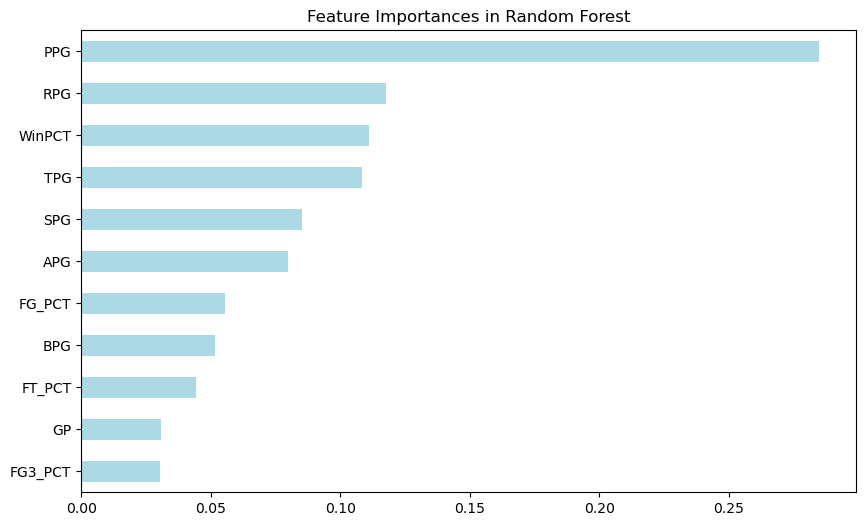

In [111]:
feature_importances = model.feature_importances_
features = X_train.columns

importances = pd.Series(feature_importances, index=features)


importances_sorted = importances.sort_values()

# Plot
plt.figure(figsize=(10,6))
importances_sorted.plot(kind='barh', color='lightblue')
plt.title('Feature Importances in Random Forest')
plt.show()


We would've expected points and win percentage to play a critical part in All-NBA selections.  However, TPG is quite surprising as it's typically viewed as a negativepredicted_probabilities_df.  We suspect that the model is rewarding high turnovers because its a sign of high usage, which the best players in basketball typically will have.

In [112]:
predicted_probabilities_df

,Player,Player_ID,Position,Year,Actual,Predicted Probability
4530,LeBron James,2544,Forward,2019-20,True,0.88
4457,Giannis Antetokounmpo,203507,Forward,2019-20,True,0.87
4583,Kawhi Leonard,202695,Forward,2019-20,True,0.86
4405,Russell Westbrook,201566,Guard,2019-20,True,0.84
4404,James Harden,201935,Guard,2019-20,True,0.81
...,...,...,...,...,...,...
3868,Timofey Mozgov,202389,Center,2017-18,False,0.00
3869,Isaiah Whitehead,1627785,Guard,2017-18,False,0.00
3870,Milton Doyle,1628495,Guard,2017-18,False,0.00
3872,James Webb III,1627821,Forward,2017-18,False,0.00


In [113]:
def mark_top_players(group):
    # Fill NaN values in 'Position' column with an empty string (or you can filter them out)
    group['Position'] = group['Position'].fillna('')

    for position in ['Guard', 'Forward', 'Center']:
        num_to_select = 6 if position in ['Guard', 'Forward'] else 3
        top_players = group[group['Position'].str.contains(position)].nlargest(num_to_select, 'Predicted Probability')
        group.loc[top_players.index, 'Predicted_AllNBA'] = True
    return group

predicted_probabilities_df['Predicted_AllNBA'] = False
predicted_probabilities_df = predicted_probabilities_df.groupby('Year', group_keys=True).apply(mark_top_players)


In [114]:
predicted_probabilities_df['Comparison'] = predicted_probabilities_df.apply(lambda x: 'Match' if (x['Actual'] == 1 and x['Predicted_AllNBA'] == 1) or (x['Actual'] == 0 and x['Predicted_AllNBA'] == 0 ) else 'Mismatch', axis=1)

In [115]:
predicted_probabilities_df[predicted_probabilities_df['Predicted_AllNBA'] == True]

Player  Player_ID        Position     Year  \
Year                                                                      
2017-18 3334           LeBron James       2544         Forward  2017-18   
        3472           Kevin Durant     201142         Forward  2017-18   
        3351           James Harden     201935           Guard  2017-18   
        3390      Russell Westbrook     201566           Guard  2017-18   
        3371          Anthony Davis     203076  Forward-Center  2017-18   
        3373       DeMarcus Cousins     202326          Center  2017-18   
        3633            Joel Embiid     203954  Center-Forward  2017-18   
        3407  Giannis Antetokounmpo     203507         Forward  2017-18   
        3474          Stephen Curry     201939           Guard  2017-18   
        3555         Victor Oladipo     203506           Guard  2017-18   
        3538      LaMarcus Aldridge     200746  Center-Forward  2017-18   
        3426         Damian Lillard     203081           Guard  2017-18   
        3634            Ben Simmons    1627732   Guard-Forward  2017-18   
2018-19 3874           James Harden     201935           Guard  2018-19   
        4050            Joel Embiid     203954  Center-Forward  2018-19   
        3980  Giannis Antetokounmpo     203507         Forward  2018-19   
        3963           Kevin Durant     201142         Forward  2018-19   
        3894            Paul George     202331         Forward  2018-19   
        4170          Kawhi Leonard     202695         Forward  2018-19   
        3895      Russell Westbrook     201566           Guard  2018-19   
        4205          Anthony Davis     203076  Forward-Center  2018-19   
        3964          Stephen Curry     201939           Guard  2018-19   
        4152           Nikola Jokic     203999          Center  2018-19   
        3947         Damian Lillard     203081           Guard  2018-19   
        4188           Kyrie Irving     202681           Guard  2018-19   
        4033       Donovan Mitchell    1628378           Guard  2018-19   
2019-20 4530           LeBron James       2544         Forward  2019-20   
        4457  Giannis Antetokounmpo     203507         Forward  2019-20   
        4583          Kawhi Leonard     202695         Forward  2019-20   
        4405      Russell Westbrook     201566           Guard  2019-20   
        4404           James Harden     201935           Guard  2019-20   
        4531          Anthony Davis     203076  Forward-Center  2019-20   
        4491            Luka Doncic    1629029   Forward-Guard  2019-20   
        4669            Joel Embiid     203954  Center-Forward  2019-20   
        4757       Domantas Sabonis    1627734  Forward-Center  2019-20   
        4566           Jayson Tatum    1628369   Forward-Guard  2019-20   
        4440           Devin Booker    1626164           Guard  2019-20   
        4473             Trae Young    1629027           Guard  2019-20   

              Actual  Predicted Probability  Predicted_AllNBA Comparison  
Year                                                                      
2017-18 3334    True                   0.91              True      Match  
        3472    True                   0.91              True      Match  
        3351    True                   0.89              True      Match  
        3390    True                   0.88              True      Match  
        3371    True                   0.83              True      Match  
        3373   False                   0.79              True   Mismatch  
        3633    True                   0.75              True      Match  
        3407    True                   0.72              True      Match  
        3474    True                   0.72              True      Match  
        3555    True                   0.72              True      Match  
        3538    True                   0.65              True      Match  
        3426    True                   0.49          

In [117]:
print(classification_report(predicted_probabilities_df['Actual'], predicted_probabilities_df['Predicted_AllNBA']))

              precision    recall  f1-score   support

       False       0.99      0.99      0.99      1557
        True       0.74      0.67      0.70        42

    accuracy                           0.98      1599
   macro avg       0.86      0.83      0.85      1599
weighted avg       0.98      0.98      0.98      1599



## Multiple Regression

In [118]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
prob_predictions = log_reg.predict_proba(X_test)
positive_class_probs = prob_predictions[:, 1]
results_df = pd.DataFrame({
    'Player': test_df['PLAYER'],
    'Player_ID': test_df['PLAYER_ID'],
    'Position': test_df['POSITION'],
    'Year': test_df['YEAR'],
    'Actual': y_test,
    'Predicted Probability': positive_class_probs
})

regression_predicted_probabilities_df = results_df.sort_values(by=['Year', 'Predicted Probability'], ascending=False)
regression_predicted_probabilities_df

/Users/omerkhan/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Player,Player_ID,Position,Year,Actual,Predicted Probability
4457,Giannis Antetokounmpo,203507,Forward,2019-20,True,9.971196e-01
4404,James Harden,201935,Guard,2019-20,True,9.905583e-01
4530,LeBron James,2544,Forward,2019-20,True,9.851617e-01
4491,Luka Doncic,1629029,Forward-Guard,2019-20,False,9.753350e-01
4531,Anthony Davis,203076,Forward-Center,2019-20,True,9.420746e-01
...,...,...,...,...,...,...
3521,Marcus Paige,1627779,Guard,2017-18,False,1.392773e-06
3855,Adreian Payne,203940,Forward,2017-18,False,8.398680e-07
3723,Antonius Cleveland,1628499,Guard,2017-18,False,7.878662e-07
3628,Gian Clavell,1628492,Guard,2017-18,False,6.122005e-07


In [119]:
regression_predicted_probabilities_df['Predicted_AllNBA'] = False
regression_predicted_probabilities_df = regression_predicted_probabilities_df.groupby('Year', group_keys=True).apply(mark_top_players)

In [120]:
regression_predicted_probabilities_df

Player  Player_ID        Position     Year  \
Year                                                                      
2017-18 3351           James Harden     201935           Guard  2017-18   
        3334           LeBron James       2544         Forward  2017-18   
        3390      Russell Westbrook     201566           Guard  2017-18   
        3371          Anthony Davis     203076  Forward-Center  2017-18   
        3407  Giannis Antetokounmpo     203507         Forward  2017-18   
...                             ...        ...             ...      ...   
2019-20 4616              Max Strus    1629622   Guard-Forward  2019-20   
        4489      Charlie Brown Jr.    1629718           Guard  2019-20   
        4863       Zach Norvell Jr.    1629668   Guard-Forward  2019-20   
        4735           Malik Newman    1629005           Guard  2019-20   
        4913      Jarred Vanderbilt    1629020         Forward  2019-20   

              Actual  Predicted Probability  Predicted_AllNBA  
Year                                                           
2017-18 3351    True           9.878601e-01              True  
        3334    True           9.853117e-01              True  
        3390    True           9.835947e-01              True  
        3371    True           9.733216e-01              True  
        3407    True           9.461500e-01              True  
...              ...                    ...               ...  
2019-20 4616   False           4.444756e-07             False  
        4489   False           4.111929e-07             False  
        4863   False           3.708215e-07             False  
        4735   False           2.979113e-07             False  
        4913   False           2.651858e-07             False  

[1599 rows x 7 columns]

In [121]:
print(classification_report(regression_predicted_probabilities_df['Actual'], regression_predicted_probabilities_df['Predicted_AllNBA']))

              precision    recall  f1-score   support

       False       0.99      0.99      0.99      1557
        True       0.68      0.62      0.65        42

    accuracy                           0.98      1599
   macro avg       0.84      0.81      0.82      1599
weighted avg       0.98      0.98      0.98      1599

